In [12]:
from pathlib import Path
import pandas as pd
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [13]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
cachedir = os.path.join(BASE_DIR, 'cache')
memory = Memory(cachedir, verbose=0)

In [14]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'staging_data' / 'hosts_reviews_en_cleaned.parquet')

In [15]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[1])

['nice', 'flat', 'great', 'area', 'host', 'sorted', 'things', 'make', 'stay', 'smooth', 'easy', 'leaving', 'key', 'neighbours', 'etc', 'thanks']


In [16]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
@memory.cache
def process_words_cached(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words_cached(data_words)

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.017*"room" + 0.015*"bed" + 0.013*"kitchen" + 0.012*"apartment" + 0.012*"good" + 0.010*"small" + 0.009*"bathroom" + 0.009*"work" + 0.008*"get" + 0.007*"night"'),
 (1,
  '0.033*"apartment" + 0.032*"walk" + 0.030*"close" + 0.024*"nice" + 0.023*"station" + 0.022*"city" + 0.019*"locate" + 0.019*"restaurant" + 0.019*"well" + 0.019*"quiet"'),
 (2,
  '0.102*"host" + 0.056*"great" + 0.052*"stay" + 0.038*"place" + 0.037*"location" + 0.035*"apartment" + 0.027*"recommend" + 0.023*"nice" + 0.022*"clean" + 0.018*"good"')]

In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percent_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.head()

,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,neighbourhood,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,comments_language,description_language,dominant_topic,percent_contribution,topic_keywords,text
0,2010-09-06,0.0,32984.0,200247.0,Keenan,great little apartment perfect spot town nice ...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,1,0.473,"apartment, walk, close, nice, station, city, l...","[great, little, apartment, perfect, spot, town..."
1,2010-09-12,0.0,32984.0,126543.0,Olaf,nice flat great area host sorted things make s...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,2,0.520,"host, great, stay, place, location, apartment,...","[nice, flat, great, area, host, sort, thing, m..."
2,2011-05-21,0.0,32984.0,294223.0,Max,great location host responsive email country t...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,0,0.618,"room, bed, kitchen, apartment, good, small, ba...","[great, location, host, responsive, email, cou..."
3,2011-05-28,0.0,32984.0,577190.0,Eli,host place super great close everything quite ...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,1,0.497,"apartment, walk, close, nice, station, city, l...","[host, place, super, great, close, quite, cent..."
4,2011-06-11,0.0,32984.0,521818.0,Jonathan,nice apartment great location great price host...,53396.0,Chris,city hall stockholm beautiful bright 43 sqm 1b...,Kungsholmens,...,4.29,4.52,4.81,4.2,en,en,2,0.536,"host, great, stay, place, location, apartment,...","[nice, apartment, great, location, great, pric..."


In [19]:
df_dominant_topic.to_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_topics.parquet')

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.068778 -0.238492       1        1  43.961352
1     -0.196787  0.172462       2        1  28.175044
0      0.265565  0.066030       3        1  27.863604, topic_info=        Term          Freq         Total Category  logprob  loglift
28      host  61304.000000  61304.000000  Default  30.0000  30.0000
8      great  33357.000000  33357.000000  Default  29.0000  29.0000
24      walk  12300.000000  12300.000000  Default  28.0000  28.0000
70     close  11430.000000  11430.000000  Default  27.0000  27.0000
48  location  24488.000000  24488.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
11    little   1896.621051   3389.853053   Topic3  -5.2992   0.6971
38     clean   2493.028155  19739.010788   Topic3  -5.0257  -0.7912
35      stay   2543.211264  38298.996794   Topic3  -5.0058  -1.4341
48  location   2352.364759  24488.543731   Topic3  -5.0838  -1.0649
50      need   1995.902877  11978.391906   Topic3  -5.2481  -0.5142

[184 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
466       1  0.958780   absolutely
466       2  0.040736   absolutely
641       1  0.999002  accommodate
116       1  0.999560       always
345       1  0.999801      amazing
...     ...       ...          ...
605       3  0.999482         wifi
887       3  0.999662       window
236       1  0.847912    wonderful
236       2  0.152043    wonderful
619       3  0.999794         work

[222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [21]:
topics = lda_model.show_topics(formatted=False)

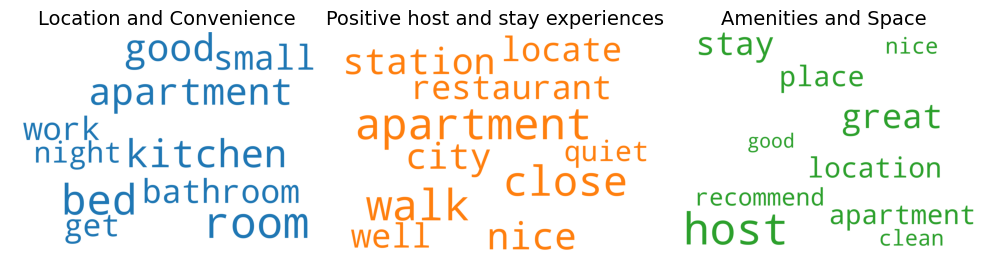

In [22]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

groups = {1: 'Positive host and stay experiences',
          0: 'Location and Convenience',
          2: 'Amenities and Space'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=20)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()